这个项目需要配置环境 pydub==0.23.1

## 关键字语音识别
欢迎来到本专业的最后一个编程任务！

在本周的视频中，你学习了如何将深度学习应用于语音识别。在此作业中，你将构建语音数据集并实现用于关键词检测（有时也称为唤醒词或触发词检测）的算法。关键词识别是一项技术，可让诸如Amazon Alexa，Google Home，Apple Siri和Baidu DuerOS之类的设备在听到某个特定单词时回应。

对于本练习，我们的触发词将是"Activate."。每次听到你说“激活”时，它都会发出“蜂鸣声”。作业完成后，你将可以录制自己的讲话片段，并在算法检测到你说"Activate"时触发提示音。

完成此任务后，也许你还可以将其扩展为在笔记本电脑上运行，以便每次你说“Activate”时，它就会启动你喜欢的应用程序，或者打开房屋中的网络连接灯，或触发其他事件？

在本作业中，你将学习：

- 构建语音识别项目
- 合成和处理音频记录以创建训练/开发数据集
- 训练关键词检测模型并做出预测

让我们开始吧！运行以下单元格以加载要使用的软件包。



In [1]:
import numpy as np
from pydub import AudioSegment
import random
import sys
import io
import os
import glob
import IPython
from td_utils import *
%matplotlib inline

ModuleNotFoundError: No module named 'pydub'

### 1 合成数据：创建语音数据集
让我们从为触发词检测算法构建数据集开始。语音数据集在理想情况下应尽可能接近要在其上运行它的应用程序。在这种情况下，你想在工作环境（图书馆，家庭，办公室，开放空间...）中检测到"activate"一词。因此，你需要在不同的背景声音上混合使用positive词("activate")和negative词（除activate以外的随机词）来创建录音。让我们看看如何创建这样的数据集。

#### 1.1 试听数据
你的一位朋友正在帮助你完成这个项目，他们去了该地区各地的图书馆，咖啡馆，餐馆，家庭和办公室，以记录背景噪音以及人们说positive/negative词的音频片段。该数据集包括以各种口音讲话的人。

在raw_data目录中，你可以找到原始音频文件的子集，包括正词，负词和背景噪音。你将使用这些音频文件来合成数据集以训练模型。"activate"目录包含人们说"activate"一词的正面示例。"negatives"目录包含人们说"activate"以外的随机单词的否定示例。每个音频记录只有一个字。"backgrounds"目录包含10秒的不同环境下的背景噪音片段。

运行下面的单元格以试听一些示例。

In [3]:
IPython.display.Audio("./raw_data/activates/1.wav")

NameError: name 'IPython' is not defined

In [4]:
IPython.display.Audio("./raw_data/negatives/4.wav")

NameError: name 'IPython' is not defined

In [5]:
IPython.display.Audio("./raw_data/backgrounds/1.wav")

NameError: name 'IPython' is not defined

你将使用这三种类型的记录(positives/negatives/backgrounds)来创建标记的数据集。

#### 1.2 从录音到频谱图

录音到底是什么？麦克风记录随时间变化很小的气压，而这些气压的微小变化也会使你的耳朵感觉到声音。你可以认为录音是一长串数字，用于测量麦克风检测到的气压变化很小。我们将使用以44100Hz（或44100赫兹）采样的音频。这意味着麦克风每秒可以为我们提供44100个号码。因此，一个10秒的音频剪辑由441000个数字表示(=10`*`44100 )。

从音频的这种“原始”表示中很难弄清是否说了"activate"这个词。为了帮助你的序列模型更轻松地学习检测触发词，我们将计算音频的spectrogram。频谱图告诉我们音频片段在某个时刻存在多少不同的频率。

（如果你曾经在信号处理或傅立叶变换方面上过高级课程，则可以通过在原始音频信号上滑动一个窗口来计算频谱图，并使用傅立叶变换来计算每个窗口中最活跃的频率。如果你不理解前面的句子，也不用担心。）

让我们来看一个例子。

In [7]:
IPython.display.Audio("audio_examples/example_train.wav")

NameError: name 'IPython' is not defined

In [8]:
x = graph_spectrogram("audio_examples/example_train.wav")

NameError: name 'graph_spectrogram' is not defined

上图表示在多个时间步长（x轴）上每个频率（y轴）的活跃程度。

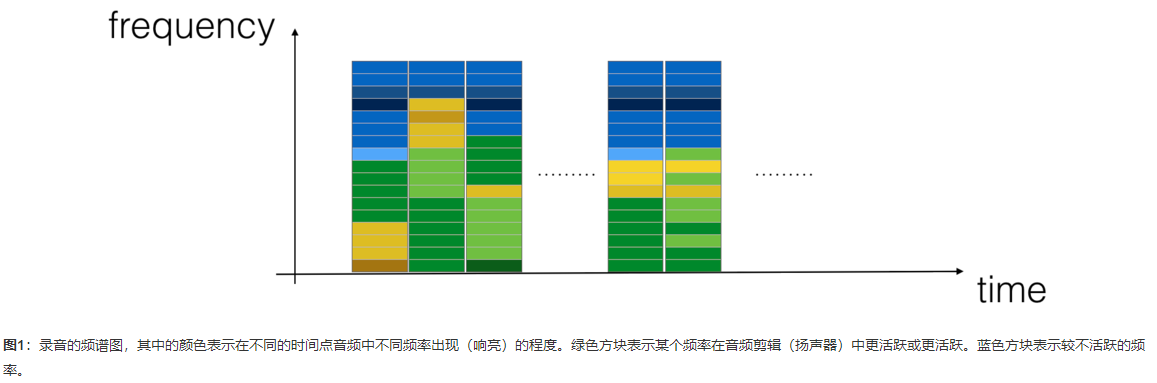

输出频谱图的尺寸取决于频谱图软件的超参数和输入的长度。在此笔记本中，我们将使用10秒的音频剪辑作为训练示例的“标准长度”。频谱图的时间步数为5511。稍后你将看到频谱图将是网络中的输入x，因此Tx=5511。

In [9]:
_, data = wavfile.read("audio_examples/example_train.wav")
print("Time steps in audio recording before spectrogram", data[:,0].shape)
print("Time steps in input after spectrogram", x.shape)

NameError: name 'wavfile' is not defined

现在，你可以定义：

In [10]:
Tx = 5511 # The number of time steps input to the model from the spectrogram
n_freq = 101 # Number of frequencies input to the model at each time step of the spectrogram

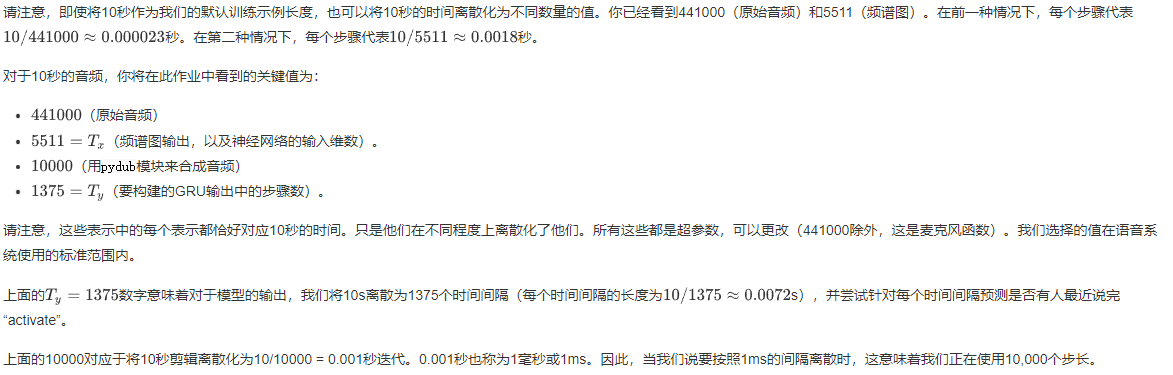

In [11]:
Ty = 1375 # The number of time steps in the output of our model

#### 1.3 生成单个训练示例
由于语音数据很难获取和标记，因此你将使用激活，否定和背景的音频片段来合成训练数据。录制很多带有随机"activates"内容的10秒音频剪辑非常慢。取而代之的是，录制许多肯定词和否定词以及分别记录背景噪音（或从免费的在线资源下载背景噪音）会变得更加容易。

要合成一个训练示例，你将：
- 随机选择10秒钟的背景音频剪辑
- 将"activates"的0-4个音频片段随机插入此10秒的片段中
- 将10个否定词的音频剪辑随机插入此10秒剪辑中
    - 我问：否定词的随机插入会切开肯定词吗？
        - 自答：这个问题后面解释了

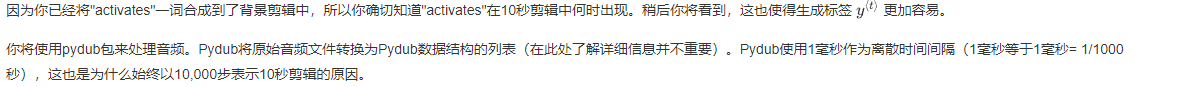

In [12]:
# Load audio segments using pydub 
activates, negatives, backgrounds = load_raw_audio()

print("background len: " + str(len(backgrounds[0])))    # Should be 10,000, since it is a 10 sec clip
print("activate[0] len: " + str(len(activates[0])))     # Maybe around 1000, since an "activate" audio clip is usually around 1 sec (but varies a lot)
print("activate[1] len: " + str(len(activates[1])))     # Different "activate" clips can have different lengths 

NameError: name 'load_raw_audio' is not defined

**在背景上叠加正/负词**：

给定一个10秒的背景剪辑和一个简短的音频剪辑(positive or negative word)，你需要能够将单词的简短音频剪辑“添加”或“插入”到背景上。为确保插入背景的音频片段不重叠，你将跟踪以前插入的音频片段的时间。你将在背景中插入多个正/负词剪辑，而又不想在与先前添加的另一个剪辑重叠的位置插入"activate"或随机词。
- 我：这里解释了，不希望单词重叠。

为了清楚起见，当你在10秒的咖啡馆噪音片段中插入1秒的 "activate" 时，你最终会得到一个10秒的片段，听起来像有人在咖啡馆中说 "activate"，背景咖啡馆噪音中叠加了 "activate" 。注意你没有以11秒的剪辑结尾。稍后你将看到pydub如何帮助你执行此操作。
- 我：正是因为是原地叠加噪声，所以说 activate 的同时还有噪声，所以音乐时长不需要变长。

**在叠加的同时创建标签**：


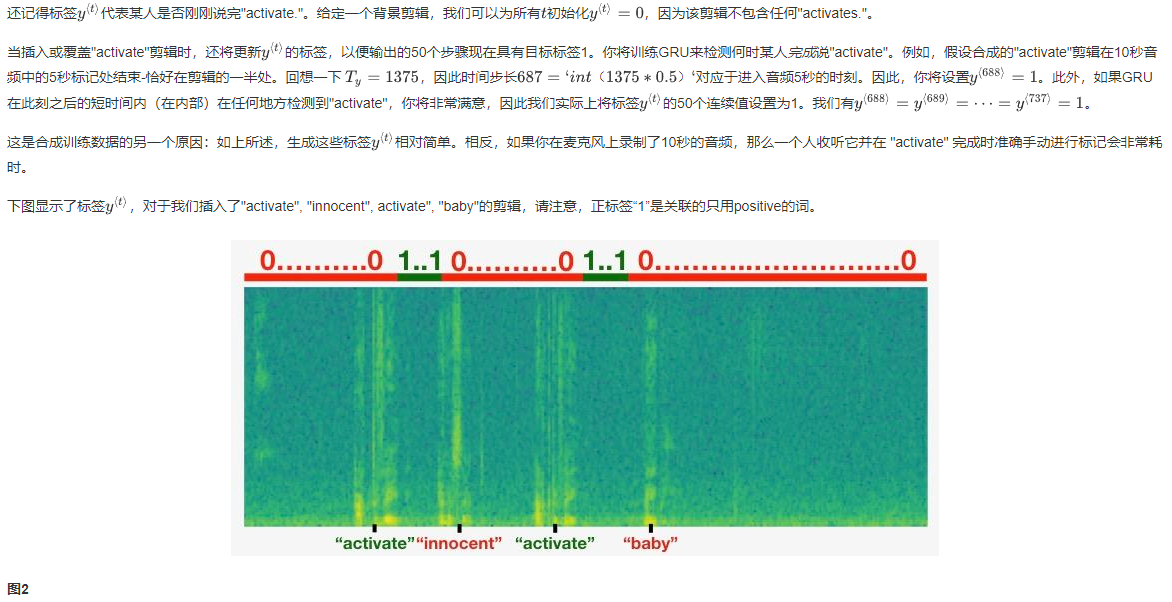

要实现合成训练集过程，你将使用以下帮助函数。所有这些函数将使用1ms的离散时间间隔，因此将10秒的音频离散化为10,000步。

1. get_random_time_segment（segment_ms）在我们的背景音频中获得随机的时间段
2. is_overlapping（segment_time，existing_segments）检查时间段是否与现有时间段重叠
3. insert_audio_clip（background，audio_clip，existing_times）使用get_random_time_segment和is_overlapping在我们的背景音频中随机插入一个音频片段。
4. insert_ones（y，segment_end_ms）在我们的标签向量y的"activate"词之后插入1。

函数 get_random_time_segment(segment_ms)返回一个随机的时间段，我们可以在其中插入持续时间为segment_ms的音频片段。 通读代码以确保你了解它在做什么。

In [13]:
def get_random_time_segment(segment_ms):
    """
    Gets a random time segment of duration segment_ms in a 10,000 ms audio clip.
    
    Arguments:
    segment_ms -- the duration of the audio clip in ms ("ms" stands for "milliseconds")
    
    Returns:
    segment_time -- a tuple of (segment_start, segment_end) in ms
    """
    
    segment_start = np.random.randint(low=0, high=10000-segment_ms)   # Make sure segment doesn't run past the 10sec background 
    segment_end = segment_start + segment_ms - 1
    
    return (segment_start, segment_end)

接下来，假设你在（1000,1800）和（3400,4500）段插入了音频剪辑。即第一个片段开始于1000步，结束于1800步。现在，如果我们考虑在（3000,3600）插入新的音频剪辑，这是否与先前插入的片段之一重叠？在这种情况下，（3000,3600）和（3400,4500）重叠，因此我们应该决定不要在此处插入片段。

出于此函数的目的，将（100,200）和（200,250）定义为重叠，因为它们在时间步200处重叠。但是，（100,199）和（200,250）是不重叠的。

**练习**：实现is_overlapping（segment_time，existing_segments）来检查新的时间段是否与之前的任何时间段重叠。你需要执行2个步骤：

1. 创建一个“False”标志，如果发现有重叠，以后将其设置为“True”。
2. 循环遍历previous_segments的开始和结束时间。将这些时间与细分的开始时间和结束时间进行比较。如果存在重叠，请将（1）中定义的标志设置为True。你可以使用：
```
for ....:  
     if ... <= ... and ... >= ...:  
         ...
```
提示：如果该段在上一个段结束之前开始，并且该段在上一个段开始之后结束，则存在重叠。

In [14]:
# GRADED FUNCTION: is_overlapping

def is_overlapping(segment_time, previous_segments):
    """
    Checks if the time of a segment overlaps with the times of existing segments.
    
    Arguments:
    segment_time -- a tuple of (segment_start, segment_end) for the new segment
    previous_segments -- a list of tuples of (segment_start, segment_end) for the existing segments
    
    Returns:
    True if the time segment overlaps with any of the existing segments, False otherwise
    """
    
    segment_start, segment_end = segment_time
    
    ### START CODE HERE ### (≈ 4 line)
    # Step 1: Initialize overlap as a "False" flag. (≈ 1 line)
    overlap = False
    
    # Step 2: loop over the previous_segments start and end times.
    # Compare start/end times and set the flag to True if there is an overlap (≈ 3 lines)
    for previous_start, previous_end in previous_segments:
        if segment_start >= previous_start and segment_start <= previous_end or segment_end >= previous_start and segment_end <= previous_end :
            overlap = True
    ### END CODE HERE ###

    return overlap


- 我：这里应该在if里面加一个break，来结束循环

In [15]:
overlap1 = is_overlapping((950, 1430), [(2000, 2550), (260, 949)])
overlap2 = is_overlapping((2305, 2950), [(824, 1532), (1900, 2305), (3424, 3656)])
print("Overlap 1 = ", overlap1)
print("Overlap 2 = ", overlap2)

Overlap 1 =  False
Overlap 2 =  True


**预期输出**:
    
Overlap 1 = False

Overlap 2 = True

现在，让我们使用以前的辅助函数在10秒钟的随机时间将新的音频片段插入到背景中，但是要确保任何新插入的片段都不会与之前的片段重叠。

**练习**：实现insert_audio_clip()以将音频片段叠加到背景10秒片段上。你将需要执行4个步骤：

1. 以ms为单位获取正确持续时间的随机时间段。
2. 确保该时间段与之前的任何时间段均不重叠。如果重叠，则返回步骤1并选择一个新的时间段。
3. 将新时间段添加到现有时间段列表中，以便跟踪你插入的所有时间段。
4. 使用pydub在背景上覆盖音频片段。我们已经为你实现了这一点。

In [16]:
# GRADED FUNCTION: insert_audio_clip

def insert_audio_clip(background, audio_clip, previous_segments):
    """
    Insert a new audio segment over the background noise at a random time step, ensuring that the 
    audio segment does not overlap with existing segments.
    
    Arguments:
    background -- a 10 second background audio recording.  
    audio_clip -- the audio clip to be inserted/overlaid. 
    previous_segments -- times where audio segments have already been placed
    
    Returns:
    new_background -- the updated background audio
    """
    
    # Get the duration of the audio clip in ms
    segment_ms = len(audio_clip)
    
    ### START CODE HERE ### 
    # Step 1: Use one of the helper functions to pick a random time segment onto which to insert 
    # the new audio clip. (≈ 1 line)
    segment_time = get_random_time_segment(segment_ms)
    # Step 2: Check if the new segment_time overlaps with one of the previous_segments. If so, keep 
    # picking new segment_time at random until it doesn't overlap. (≈ 2 lines)
    while is_overlapping(segment_time,previous_segments):
        segment_time = get_random_time_segment(segment_ms)

    # Step 3: Add the new segment_time to the list of previous_segments (≈ 1 line)
    previous_segments.append(segment_time)
    ### END CODE HERE ###
    
    # Step 4: Superpose audio segment and background
    new_background = background.overlay(audio_clip, position = segment_time[0])
    
    return new_background, segment_time

In [17]:
np.random.seed(5)
audio_clip, segment_time = insert_audio_clip(backgrounds[0], activates[0], [(3790, 4400)])
audio_clip.export("insert_test.wav", format="wav")
print("Segment Time: ", segment_time)
IPython.display.Audio("insert_test.wav")

NameError: name 'backgrounds' is not defined

**预期输出**

Segment Time: (2915, 3569)

In [18]:
# Expected audio
IPython.display.Audio("audio_examples/insert_reference.wav")

NameError: name 'IPython' is not defined

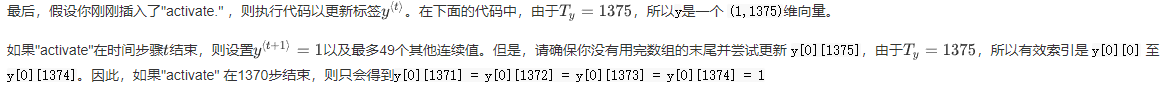

**练习**：实现insert_ones()。你可以使用for循环。（如果你是python的slice运算的专家，请随时使用切片对此向量化。）如果段以segment_end_ms结尾（使用10000步离散化），请将其转换为输出y的索引（使用1375步离散化），我们将使用以下公式：
```
    segment_end_y = int(segment_end_ms * Ty / 10000.0)
```

In [21]:
# GRADED FUNCTION: insert_ones

def insert_ones(y, segment_end_ms):
    """
    Update the label vector y. The labels of the 50 output steps strictly after the end of the segment 
    should be set to 1. By strictly we mean that the label of segment_end_y should be 0 while, the
    50 followinf labels should be ones.
    
    
    Arguments:
    y -- numpy array of shape (1, Ty), the labels of the training example
    segment_end_ms -- the end time of the segment in ms
    
    Returns:
    y -- updated labels
    """
    
    # duration of the background (in terms of spectrogram time-steps)
    segment_end_y = int(segment_end_ms * Ty / 10000.0)
    
    # Add 1 to the correct index in the background label (y)
    ### START CODE HERE ### (≈ 3 lines)
    for i in range(segment_end_y+1, segment_end_y+51):
        if i < Ty:
            y[0, i] = 1
    ### END CODE HERE ###
    
    return y

In [22]:
arr1 = insert_ones(np.zeros((1, Ty)), 9700)
plt.plot(insert_ones(arr1, 4251)[0,:])
print("sanity checks:", arr1[0][1333], arr1[0][634], arr1[0][635])

NameError: name 'plt' is not defined

**预期输出**

sanity checks: 0.0 1.0 0.0

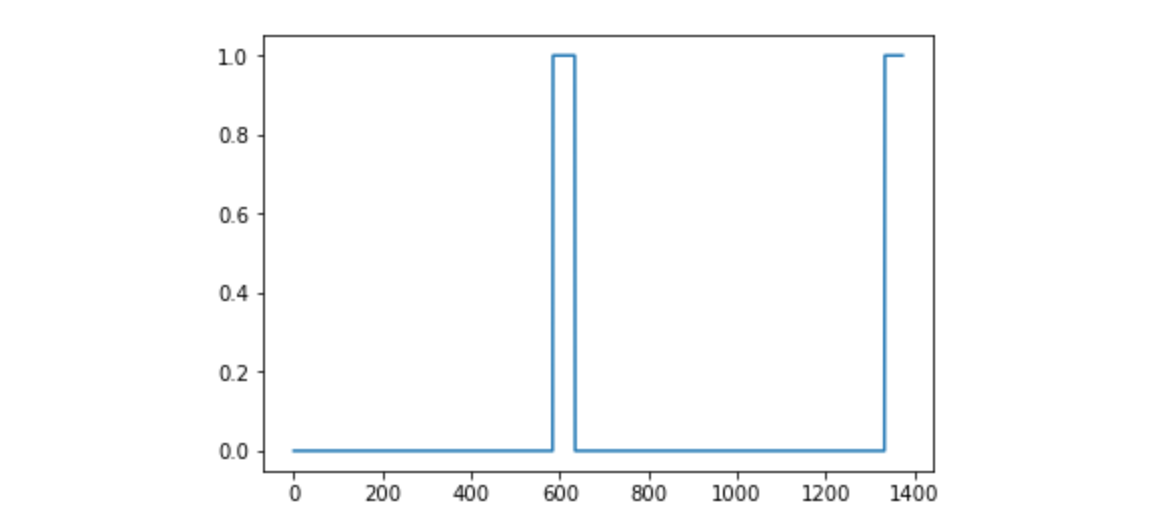

最后，你可以使用insert_audio_clip和 insert_ones来创建一个新的训练示例。

**练习**：实现create_training_example()。你需要执行以下步骤：

1. 将标签向量y初始化为维度为(1,Ty)的零numpy数组
2. 将现有段的集合初始化为一个空列表
3. 随机选择0到4个"activate"音频剪辑，并将其插入10秒剪辑中。还要在标签向量的正确位置插入标签。
4. 随机选择0到2个负音频片段，并将其插入10秒片段中。

In [23]:
# GRADED FUNCTION: create_training_example

def create_training_example(background, activates, negatives):
    """
    Creates a training example with a given background, activates, and negatives.
    
    Arguments:
    background -- a 10 second background audio recording
    activates -- a list of audio segments of the word "activate"
    negatives -- a list of audio segments of random words that are not "activate"
    
    Returns:
    x -- the spectrogram of the training example
    y -- the label at each time step of the spectrogram
    """
    
    # Set the random seed
    np.random.seed(18)
    
    # Make background quieter
    background = background - 20

    ### START CODE HERE ###
    # Step 1: Initialize y (label vector) of zeros (≈ 1 line)
    y = np.zeros((1, Ty))

    # Step 2: Initialize segment times as empty list (≈ 1 line)
    previous_segments = []
    ### END CODE HERE ###
    
    # Select 0-4 random "activate" audio clips from the entire list of "activates" recordings
    number_of_activates = np.random.randint(0, 5)
    random_indices = np.random.randint(len(activates), size=number_of_activates)
    random_activates = [activates[i] for i in random_indices]
    
    ### START CODE HERE ### (≈ 3 lines)
    # Step 3: Loop over randomly selected "activate" clips and insert in background
    for random_activate in random_activates:
        # Insert the audio clip on the background
        background, segment_time = insert_audio_clip(background, random_activate, previous_segments)
        # Retrieve segment_start and segment_end from segment_time
        segment_start, segment_end = segment_time
        # Insert labels in "y"
        y = insert_ones(y, segment_end)
    ### END CODE HERE ###

    # Select 0-2 random negatives audio recordings from the entire list of "negatives" recordings
    number_of_negatives = np.random.randint(0, 3)
    random_indices = np.random.randint(len(negatives), size=number_of_negatives)
    random_negatives = [negatives[i] for i in random_indices]

    ### START CODE HERE ### (≈ 2 lines)
    # Step 4: Loop over randomly selected negative clips and insert in background
    for random_negative in random_negatives:
        # Insert the audio clip on the background 
        background, _ = insert_audio_clip(background, random_negative, previous_segments)
    ### END CODE HERE ###
    
    # Standardize the volume of the audio clip 
    background = match_target_amplitude(background, -20.0)

    # Export new training example 
    file_handle = background.export("train" + ".wav", format="wav")
    print("File (train.wav) was saved in your directory.")
    
    # Get and plot spectrogram of the new recording (background with superposition of positive and negatives)
    x = graph_spectrogram("train.wav")
    
    return x, y

In [24]:
x, y = create_training_example(backgrounds[0], activates, negatives)

NameError: name 'backgrounds' is not defined

**预期输出**

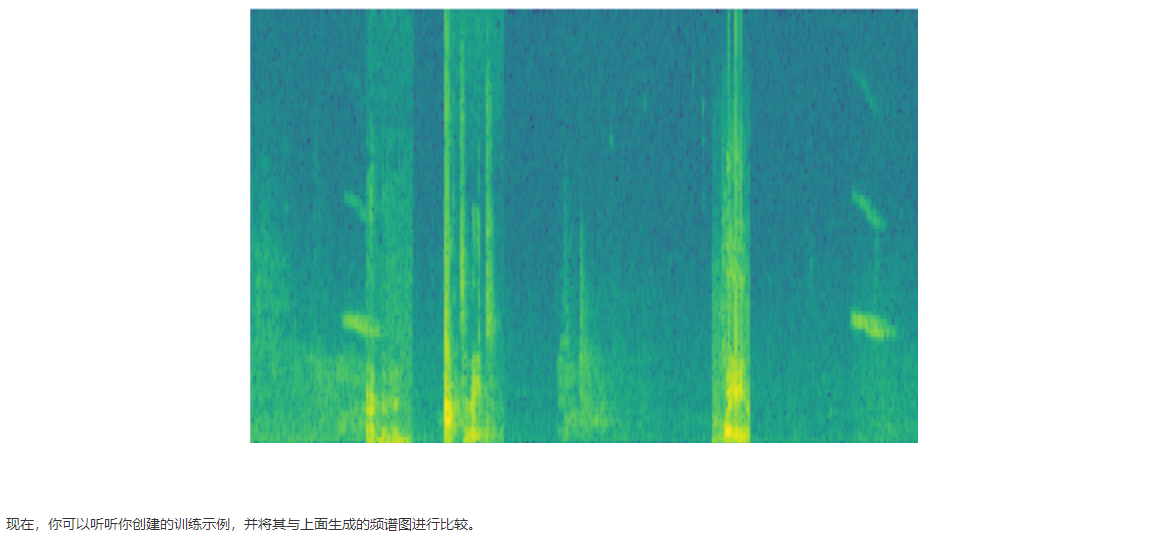



In [25]:
IPython.display.Audio("train.wav")

NameError: name 'IPython' is not defined

**预期输出**

In [26]:
IPython.display.Audio("audio_examples/train_reference.wav")

NameError: name 'IPython' is not defined

最后，你可以为生成的训练示例绘制关联的标签。

In [27]:
plt.plot(y[0])

NameError: name 'plt' is not defined

**预期输出**

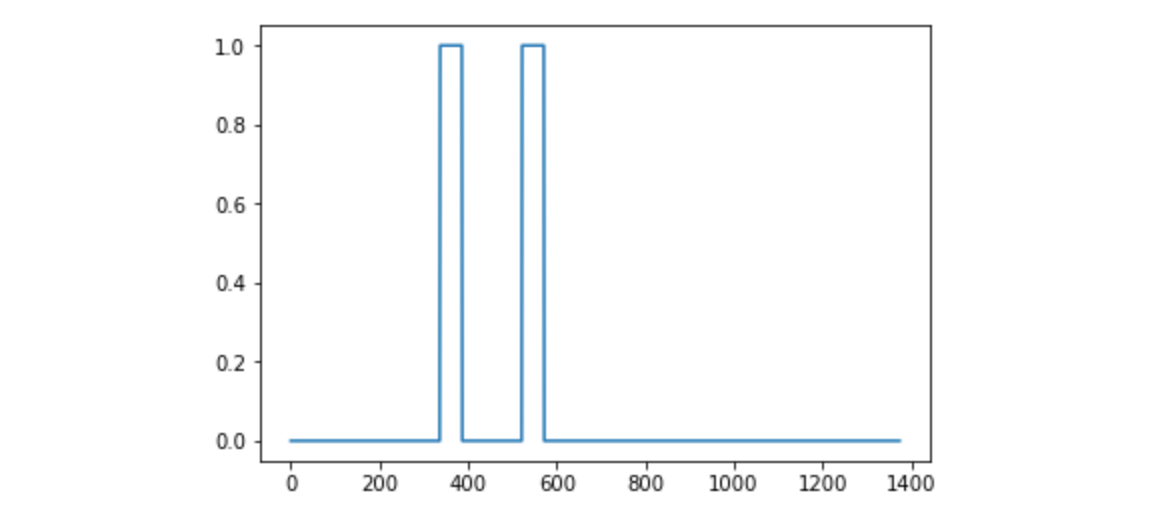

### 1.4 完整训练集
现在，你已经实现了生成单个训练示例所需的代码。我们使用此过程生成了大量的训练集。为了节省时间，我们已经生成了一组训练示例。



In [28]:
# Load preprocessed training examples
X = np.load("./XY_train/X.npy")
Y = np.load("./XY_train/Y.npy")

FileNotFoundError: [Errno 2] No such file or directory: './XY_train/X.npy'

#### 1.5 开发集
为了测试我们的模型，我们记录了包含25个示例的开发集。在合成训练数据的同时，我们希望使用与实际输入相同的分布来创建开发集。因此，我们录制了25个10秒钟的人们说"activate"和其他随机单词的音频剪辑，并手动标记了它们。这遵循课程3中描述的原则，即我们应该将开发集创建为与测试集尽可能相似。这就是为什么我们的开发人员使用真实音频而非合成音频的原因。



In [29]:
# Load preprocessed dev set examples
X_dev = np.load("./XY_dev/X_dev.npy")
Y_dev = np.load("./XY_dev/Y_dev.npy")

FileNotFoundError: [Errno 2] No such file or directory: './XY_dev/X_dev.npy'

### 2 模型
现在，你已经建立了数据集，让我们编写和训练关键字识别模型！

该模型将使用一维卷积层，GRU层和密集层。让我们加载在Keras中使用这些层的软件包。加载可能需要一分钟。



In [30]:
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam

ImportError: cannot import name 'Adam'

#### 2.1 建立模型
这是我们将使用的模型架构。花一些时间查看模型，看看它是否合理。

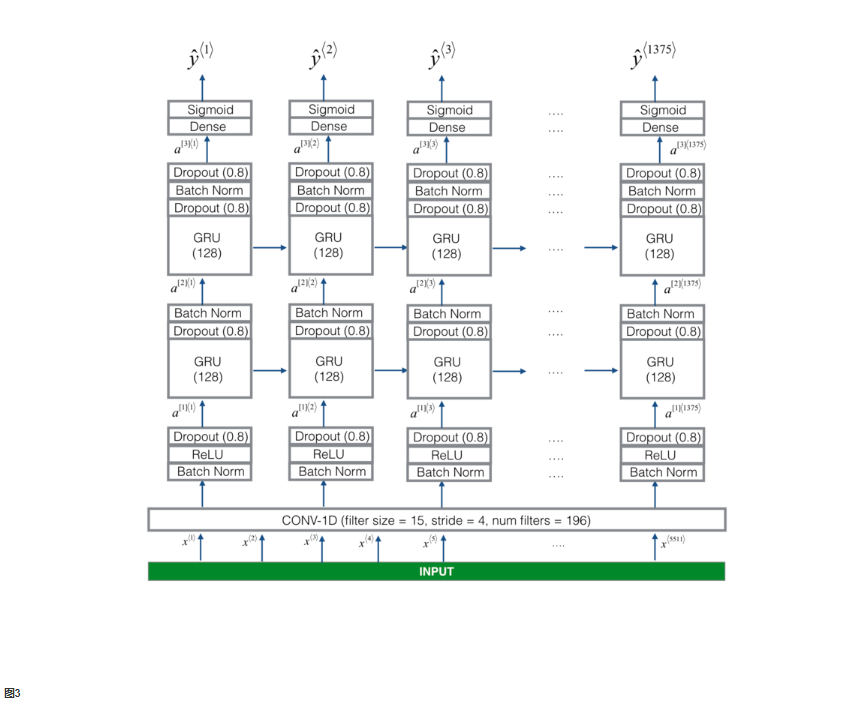

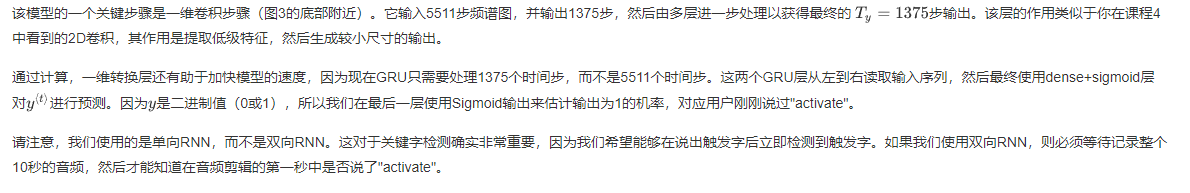

可以通过四个步骤来实现模型：
    
**步骤1**：CONV层。使用Conv1D()和196个滤波器来实现，
滤波器大小为15（kernel_size = 15），步幅为4。 [See documentation.]

**步骤2**：第一个GRU层。要生成GRU层，请使用：

`X = GRU(units = 128, return_sequences = True)(X)`

设置return_sequences = True可以确保所有GRU的隐藏状态都被feed到下一层。请记住，在Dropout和BatchNorm层之后进行此操作。

**步骤3**：第二个GRU层。这类似于先前的GRU层（请记住使用return_sequences = True），但是有一个额外的dropout层。

**步骤4**：按以下步骤创建一个时间分布的密集层：

`X = TimeDistributed(Dense(1, activation = "sigmoid"))(X)`

这将创建一个紧随其后的Sigmoid密集层，因此用于密集层的参数对于每个时间步都是相同的。[See documentation.]

**练习**：实现model()，其架构如图3所示。


In [31]:
# GRADED FUNCTION: model

def model(input_shape):
    """
    Function creating the model's graph in Keras.
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)

    Returns:
    model -- Keras model instance
    """
    
    X_input = Input(shape = input_shape)
    
    ### START CODE HERE ###
    
    # Step 1: CONV layer (≈4 lines)
    X = Conv1D(196, 15, strides=4)(X_input)                    # CONV1D
    X = BatchNormalization()(X)                                # Batch normalization
    X = Activation('relu')(X)                                  # ReLu activation
    X = Dropout(0.8)(X)                                        # dropout (use 0.8)

    # Step 2: First GRU Layer (≈4 lines)
    X = GRU(units = 128, return_sequences=True)(X)             # GRU (use 128 units and return the sequences)
    X = Dropout(0.8)(X)                                        # dropout (use 0.8)
    X = BatchNormalization()(X)                                # Batch normalization
    
    # Step 3: Second GRU Layer (≈4 lines)
    X = GRU(units = 128, return_sequences=True)(X)             # GRU (use 128 units and return the sequences)
    X = Dropout(0.8)(X)                                        # dropout (use 0.8)
    X = BatchNormalization()(X)                                # Batch normalization
    X = Dropout(0.8)(X)                                        # dropout (use 0.8)
    
    # Step 4: Time-distributed dense layer (≈1 line)
    X = TimeDistributed(Dense(1, activation = "sigmoid"))(X) # time distributed  (sigmoid)

    ### END CODE HERE ###

    model = Model(inputs = X_input, outputs = X)
    
    return model  


In [32]:
model = model(input_shape = (Tx, n_freq))

让我们输出模型总结以查看维度。



In [33]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5511, 101)]       0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1375, 196)         297136    
_________________________________________________________________
batch_normalization (BatchNo (None, 1375, 196)         784       
_________________________________________________________________
activation (Activation)      (None, 1375, 196)         0         
_________________________________________________________________
dropout (Dropout)            (None, 1375, 196)         0         
_________________________________________________________________
gru (GRU)                    (None, 1375, 128)         125184    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1375, 128)         0     

网络的输出为（None，1375，1），输入为（None，5511，101）。Conv1D将步数从频谱图上的5511减少到1375。

#### 2.2 拟合模型
关键词检测需要很长时间来训练。为了节省时间，我们已经使用你上面构建的架构在GPU上训练了大约3个小时的模型，并提供了大约4000个示例的大型训练集。让我们加载模型吧。

In [35]:
model = load_model('./models/tr_model.h5')

OSError: SavedModel file does not exist at: ./models/tr_model.h5\{saved_model.pbtxt|saved_model.pb}

你可以使用Adam优化器和二进制交叉熵损失进一步训练模型，如下所示。这将很快运行，因为我们只训练一个epoch，并提供26个例子的小训练集。

In [36]:
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])

NameError: name 'Adam' is not defined

In [37]:
model.fit(X, Y, batch_size = 5, epochs=1)

NameError: name 'X' is not defined

#### 2.3 测试模型
最后，让我们看看你的模型在开发集上的表现。




In [40]:
loss, acc = model.evaluate(X_dev, Y_dev)
print("Dev set accuracy = ", acc)

NameError: name 'X_dev' is not defined

看起来不错！但是，精度并不是这项任务的重要指标，因为标签严重偏斜到0，因此仅输出0的神经网络的精度将略高于90％。我们可以定义更有用的指标，例如F1得分或“精确度/召回率”。但是，我们不要在这里使用它，而只是凭经验看看模型是如何工作的。

### 3 预测
现在，你已经建立了用于触发词检测的工作模型，让我们使用它来进行预测吧。此代码段通过网络运行音频（保存在wav文件中）。

可以使用你的模型对新的音频片段进行预测。

你首先需要计算输入音频剪辑的预测。

**练习**：实现predict_activates（）。你需要执行以下操作：

1. 计算音频文件的频谱图
2. 使用np.swap和np.expand_dims将输入调整为（1，Tx，n_freqs）大小
3. 在模型上使用正向传播来计算每个输出步骤的预测

In [41]:
def detect_triggerword(filename):
    plt.subplot(2, 1, 1)

    x = graph_spectrogram(filename)
    # the spectogram outputs (freqs, Tx) and we want (Tx, freqs) to input into the model
    x  = x.swapaxes(0,1)
    x = np.expand_dims(x, axis=0)
    predictions = model.predict(x)
    
    plt.subplot(2, 1, 2)
    plt.plot(predictions[0,:,0])
    plt.ylabel('probability')
    plt.show()
    return predictions

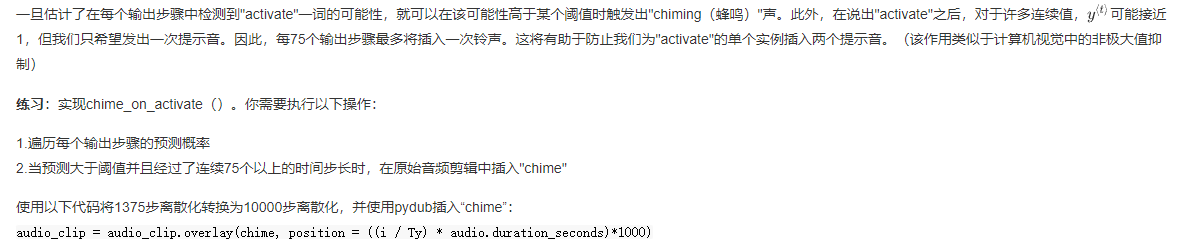

In [42]:
chime_file = "audio_examples/chime.wav"
def chime_on_activate(filename, predictions, threshold):
    audio_clip = AudioSegment.from_wav(filename)
    chime = AudioSegment.from_wav(chime_file)
    Ty = predictions.shape[1]
    # Step 1: Initialize the number of consecutive output steps to 0
    consecutive_timesteps = 0
    # Step 2: Loop over the output steps in the y
    for i in range(Ty):
        # Step 3: Increment consecutive output steps
        consecutive_timesteps += 1
        # Step 4: If prediction is higher than the threshold and more than 75 consecutive output steps have passed
        if predictions[0,i,0] > threshold and consecutive_timesteps > 75:
            # Step 5: Superpose audio and background using pydub
            audio_clip = audio_clip.overlay(chime, position = ((i / Ty) * audio_clip.duration_seconds)*1000)
            # Step 6: Reset consecutive output steps to 0
            consecutive_timesteps = 0
        
    audio_clip.export("chime_output.wav", format='wav')

- 我：因为实时侦测到activate后播放蜂鸣声比较麻烦，本实验采取在原始测试音频的相应位置插入蜂鸣音的方法来模拟；这样播放测试音频时，activate后就会跟上蜂鸣声

#### 3.1 测试开发集
让我们探讨一下我们的模型在开发集中的两个未知的音频剪辑上表现如何。首先让我们听听两个开发集剪辑。



In [43]:
IPython.display.Audio("./raw_data/dev/1.wav")

NameError: name 'IPython' is not defined

In [44]:
IPython.display.Audio("./raw_data/dev/2.wav")

NameError: name 'IPython' is not defined

现在，让我们在这些音频剪辑上运行模型，看看在"activate"之后它是否添加了提示音！

In [45]:
filename = "./raw_data/dev/1.wav"
prediction = detect_triggerword(filename)
chime_on_activate(filename, prediction, 0.5)
IPython.display.Audio("./chime_output.wav")

NameError: name 'plt' is not defined

In [46]:
filename  = "./raw_data/dev/2.wav"
prediction = detect_triggerword(filename)
chime_on_activate(filename, prediction, 0.5)
IPython.display.Audio("./chime_output.wav")

NameError: name 'plt' is not defined

恭喜，你已结束本作业！

这是你应该记住的：

- 数据合成是创建针对语音问题（尤其是触发词检测）大型训练集的有效方法。
- 在将音频数据传递到RNN，GRU或LSTM之前，使用频谱图和可选的1D转换层是常见的预处理步骤。
- 可以使用端到端的深度学习方法来构建非常有效的触发词检测系统。

恭喜完成最后的作业！

感谢你一直坚持到底，并感谢你为学习深度学习付出的辛勤工作。希望你喜欢这个课程！

### 4 试试你自己的例子！（可选练习）
略